In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import joblib
import os
import json
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
# ratings_json_file = os.path.join("/content/drive/MyDrive/MLIP_Project/Data Collection/02 14 Data Ratings & Movies/Ratings_data.json")
# with open(ratings_json_file, "r") as file:
#     data = json.load(file)

df = pd.read_csv("moviedata.csv")
df.head()

,timestamp,userid,request,movieid,rating
0,2024-03-16 11:52:41,407291,GET /rate/standing+in+the+shadows+of+motown+20...,standing+in+the+shadows+of+motown+2002,3.0
1,2024-03-16 11:52:41,435201,GET /rate/kes+1969=5,kes+1969,5.0
2,2024-03-16 11:52:41,154182,GET /rate/schindlers+list+1993=4,schindlers+list+1993,4.0
3,2024-03-16 11:52:43,598328,GET /rate/my+neighbor+totoro+1988=3,my+neighbor+totoro+1988,3.0
4,2024-03-16 11:52:43,662024,GET /rate/spirited+away+2001=4,spirited+away+2001,4.0


In [3]:
df = df[pd.notnull(df['movieid'])]
df.isnull().sum()

timestamp    4328
userid          0
request         0
movieid         0
rating          0
dtype: int64

In [4]:
# Map user ID to a "user vector" via an embedding matrix
user_ids = df["userid"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# Map movies ID to a "movies vector" via an embedding matrix
movie_ids = df["movieid"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df["user"] = df["userid"].map(user2user_encoded)
df["movie"] = df["movieid"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df['rating'] = df['rating'].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(f"Number of users: {num_users}, Number of Movies: {num_movies}, Min Rating: {min_rating}, Max Rating: {max_rating}")

Number of users: 208422, Number of Movies: 23279, Min Rating: 1.0, Max Rating: 5.0


In [5]:
df.head()

,timestamp,userid,request,movieid,rating,user,movie
0,2024-03-16 11:52:41,407291,GET /rate/standing+in+the+shadows+of+motown+20...,standing+in+the+shadows+of+motown+2002,3.0,0,0
1,2024-03-16 11:52:41,435201,GET /rate/kes+1969=5,kes+1969,5.0,1,1
2,2024-03-16 11:52:41,154182,GET /rate/schindlers+list+1993=4,schindlers+list+1993,4.0,2,2
3,2024-03-16 11:52:43,598328,GET /rate/my+neighbor+totoro+1988=3,my+neighbor+totoro+1988,3.0,3,3
4,2024-03-16 11:52:43,662024,GET /rate/spirited+away+2001=4,spirited+away+2001,4.0,4,4


In [6]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values

# Normalizing the targets between 0 and 1.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Splitting the dataset into training and validation sets (80% training, 20% validation)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.20, random_state=42)

In [7]:
x_val

array([[159529,     11],
       [127990,  10164],
       [  2154,  17590],
       ...,
       [ 71759,    120],
       [170330,     71],
       [ 33383,   8442]])

In [26]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to be between 0 and 11
        return tf.nn.sigmoid(x)

model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.01)
)

In [27]:
start_time = time.time()
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=20,
    verbose=1,
    validation_data=(x_val, y_val)
)
end_time = time.time()

print("Training time: ", end_time - start_time, "seconds")

Epoch 1/20
3160/3160 [==============================] - 28s 9ms/step - loss: 0.6230 - val_loss: 0.5963
Epoch 2/20
3160/3160 [==============================] - 26s 8ms/step - loss: 0.5905 - val_loss: 0.6140
Epoch 3/20
3160/3160 [==============================] - 26s 8ms/step - loss: 0.5840 - val_loss: 0.6178
Epoch 4/20
3160/3160 [==============================] - 26s 8ms/step - loss: 0.5816 - val_loss: 0.6136
Epoch 5/20
3160/3160 [==============================] - 26s 8ms/step - loss: 0.5797 - val_loss: 0.6133
Epoch 6/20
3160/3160 [==============================] - 26s 8ms/step - loss: 0.5774 - val_loss: 0.6128
Epoch 7/20
3160/3160 [==============================] - 26s 8ms/step - loss: 0.5752 - val_loss: 0.6129
Epoch 8/20
3160/3160 [==============================] - 26s 8ms/step - loss: 0.5729 - val_loss: 0.6123
Epoch 9/20
3160/3160 [==============================] - 25s 8ms/step - loss: 0.5703 - val_loss: 0.6112
Epoch 10/20
3160/3160 [==============================] - 26s 8ms/step - l

In [28]:
model.summary()
total_parameters = model.count_params()
print("Total parameters: ", total_parameters)

# Assuming float32 for each parameter
memory_per_parameter = 4  # bytes
total_memory = total_parameters * memory_per_parameter

print("Approximate memory size of the model: ", total_memory, "bytes")

Model: "recommender_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     multiple                  10421100  
                                                                 
 embedding_5 (Embedding)     multiple                  208422    
                                                                 
 embedding_6 (Embedding)     multiple                  1163950   
                                                                 
 embedding_7 (Embedding)     multiple                  23279     
                                                                 
Total params: 11816751 (45.08 MB)
Trainable params: 11816751 (45.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Total parameters:  11816751
Approximate memory size of the model:  47267004 bytes


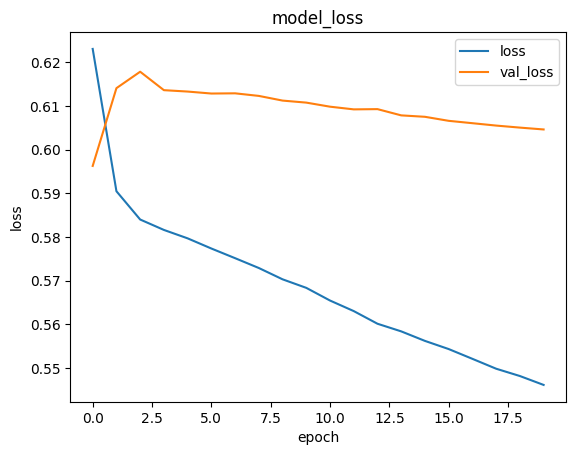

In [29]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

In [30]:
start_time = time.time()
ratings = model.predict(x_val).flatten()
end_time = time.time()

print("Inference time for x_val: ", end_time - start_time, "seconds")

1580/1580 [==============================] - 3s 2ms/step
Inference time for x_val:  5.224217414855957 seconds


In [31]:
# Calculate RMSE
mse = mean_squared_error(y_val, ratings)
rmse = np.sqrt(mse)
print("Root Mean Square Error: ", rmse)

# Calculate MAE
mae = mean_absolute_error(y_val, ratings)
print("Mean Absolute Error: ", mae)

Root Mean Square Error:  0.18974847693013072
Mean Absolute Error:  0.1514474857912534


In [32]:
model.save('/content/keras_model', save_format='tf')

In [36]:
model.save_weights('/content/model_weights')

In [34]:
given_user_id = userencoded2user[71759]
given_user_id

'1015'

In [35]:
# Assuming 'userid' is the user ID for whom we want to recommend movies
given_user_id = '1015'

# Encode the user ID
encoded_user_id = user2user_encoded.get(given_user_id)

# Get all movie IDs in the dataset
all_movie_ids = list(movie2movie_encoded.keys())

# Find movies that the user has already rated
movies_rated_by_user = df[df['userid'] == given_user_id]['movieid'].unique()

# Find movies that the user has NOT rated yet
movies_not_rated_by_user = [movie_id for movie_id in all_movie_ids if movie_id not in movies_rated_by_user]

# Prepare the input for the model: a list of [user, movie] pairs for the given user and all movies they haven't rated
user_movie_pairs = np.array([[encoded_user_id, movie2movie_encoded[movie_id]] for movie_id in movies_not_rated_by_user])

# Predict ratings for these pairs
predicted_ratings = model.predict(user_movie_pairs).flatten()

# Combine the movie IDs and their predicted ratings
movie_ratings_pairs = list(zip(movies_not_rated_by_user, predicted_ratings))

# Sort the movies by their predicted ratings in descending order
movie_ratings_pairs.sort(key=lambda x: x[1], reverse=True)

# Extract the top 20 movies
top_20_movies = movie_ratings_pairs[:20]

# Print the top 20 recommended movies for the user
print(f"Top 20 recommended movies for user {given_user_id} are:")
for movie_id, rating in top_20_movies:
    print(f"Movie ID: {movie_id}, Predicted Rating: {rating}")

728/728 [==============================] - 1s 2ms/step
Top 20 recommended movies for user 1015 are:
Movie ID: death+proof+2007, Predicted Rating: 0.9488669037818909
Movie ID: jackie+brown+1997, Predicted Rating: 0.923087477684021
Movie ID: django+unchained+2012, Predicted Rating: 0.9085724949836731
Movie ID: hail+the+conquering+hero+1944, Predicted Rating: 0.8631396293640137
Movie ID: the+naked+city+1948, Predicted Rating: 0.8458929657936096
Movie ID: the+shawshank+redemption+1994, Predicted Rating: 0.8434612154960632
Movie ID: the+little+foxes+1941, Predicted Rating: 0.8341657519340515
Movie ID: bennys+video+1993, Predicted Rating: 0.8333409428596497
Movie ID: eternal+sunshine+of+the+spotless+mind+2004, Predicted Rating: 0.8307790756225586
Movie ID: rear+window+1954, Predicted Rating: 0.8307139277458191
Movie ID: early+summer+1951, Predicted Rating: 0.8256525993347168
Movie ID: a+grand+day+out+1990, Predicted Rating: 0.8212624788284302
Movie ID: the+godfather+1972, Predicted Rating: 0